In [2]:
# Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from config import params, base_url

def wine_dropna(wine_data, col): 
    wine_data.dropna(subset=[col], inplace = True)
    print("wine_data size, after dropping NaN for "+ col + ": " + str(wine_data.shape))

def get_country_data(data, country): 
    ret_df = data.loc[data['country'] == country].copy()
    if ret_df.shape[0] > 0: 
        print('Record count for Country, ' + str(country) + ': ' + str(ret_df.shape))
        return ret_df
    else: 
        return None

def get_g_address(winery_geo): 

    formatted_address = winery_geo["results"][0]['formatted_address']
    formed_address_list = winery_geo["results"][0]['address_components']
    try: 
        street_number = formed_address_list[0]['long_name']
        route = formed_address_list[1]['long_name']
        locality = formed_address_list[2]['long_name']
        administrative_area_level_2 = formed_address_list[3]['long_name']
        administrative_area_level_1 = formed_address_list[4]['long_name']
        g_country = formed_address_list[5]['long_name']
        postal_code = formed_address_list[6]['long_name']
    except: 
        return None
    
    ret_data = (formatted_address, formed_address_list, 
                street_number, route, locality, administrative_area_level_2, administrative_area_level_1, g_country, postal_code)
    return ret_data

def check_match(formed_address, province, country): 
    return country != formed_address[7] or province != formed_address[5]

def write_results(out_path, content): 
    out_dir_name = os.path.dirname(out_path)

    if not os.path.exists(out_dir_name): 
        os.mkdir(out_dir_name, 511)
    file_name = os.path.split(out_path)[1]
    
    with open(os.path.join(out_dir_name, file_name), 'a') as ctx: 
        ctx.write(content)

wine_data = pd.read_csv('Data/winemag-data-130k-v2.csv')
wine_data.head()

cleaned_wine_data_ind_cntrs = wine_data.copy()
cleaned_wine_data_all_cntrs = wine_data.copy()

non_nullable_colums_for_individual_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name', 
                       'region_1'
                      ]

non_nullable_colums_for_all_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name'
                      ]

countries = list(cleaned_wine_data_ind_cntrs.country.unique())

print(countries)
print(len(countries))

for cols in non_nullable_colums_for_individual_countries: 
    wine_dropna(cleaned_wine_data_ind_cntrs, cols)
    
for cols in non_nullable_colums_for_all_countries: 
    wine_dropna(cleaned_wine_data_all_cntrs, cols)

data_columns_for_study = ['title', 'description', # Wine
                          'taster_name', 'taster_twitter_handle', 'points', 'price', # Rating
                          'variety', 'winery', # Wine Type
                          'province', 'region_1', 'country' # Area
                         ]
cleaned_wine_data_ind_cntrs = cleaned_wine_data_ind_cntrs[data_columns_for_study]
cleaned_wine_data_all_cntrs = cleaned_wine_data_all_cntrs[data_columns_for_study]

country_data = pd.DataFrame()
print(base_url)
unfound_winery = [{}]
for country in countries: 
    country_data = get_country_data(cleaned_wine_data_ind_cntrs, country)
    
    if isinstance(country_data, pd.DataFrame):
        if (country == 'Canada'): 
            print(country)
            country_data['latitude'] = ''
            country_data['longitude'] = ''
            country_data['g_address'] = ''
            country_data.index = pd.RangeIndex(len(country_data.index))
            address_dict = {}
            for index, row in country_data.iterrows(): 
                #print(index)
                winery_address = f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"
                if not winery_address in address_dict.keys(): 
                    address_dict.update({winery_address: []})
                    params['address'] = winery_address
                    response = requests.get(base_url, params=params)
                    # print(response)
                    if response.status_code == 200:
                    # Extracting data in json format
                        winery_geo = response.json()
                        if winery_geo.get("results", []):
                            lat = winery_geo["results"][0]["geometry"]["location"]["lat"]
                            lon = winery_geo["results"][0]["geometry"]["location"]["lng"]
                        else: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            address_dict.pop(winery_address)
                            continue
                    formed_address = get_g_address(winery_geo)
                    if formed_address == None: 
                        unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                        country_data.drop([index])
                        address_dict.pop(winery_address)
                        continue
                    check_match_count = 0
                    is_winery_add_found = True
                    while not check_match(formed_address, row['province'], country): 
                        check_match_count += 1
                        params['address'] = f"{row['region_1']}, {row['province']}, {row['country']}"
                        response = requests.get(base_url, params=params)
                        winery_geo = response.json()
                        formed_address = get_g_address(winery_geo)
                        if check_match_count > 1: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            is_winery_add_found = False
                            address_dict.pop(winery_address)
                            break
                    if not is_winery_add_found: 
                        continue

                    formed_address = f'{formed_address[2]}~~~~{formed_address[3]}~~~~{formed_address[4]}~~~~{formed_address[5]}~~~~{formed_address[6]}~~~~{formed_address[7]}~~~~{formed_address[8]}'
                    
                    address_dict[winery_address] = [lat, lon, formed_address]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
                    # print(f"Winery: {winery_address} ; LAT: {lat} ; LON: {lon}; Address: {formed_address}")
                else: 
                    lat = address_dict[winery_address][0]
                    lon = address_dict[winery_address][1]
                    formed_address = address_dict[winery_address][2]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
            print(country_data.shape)
            country_data['g_address'].replace('', np.nan, inplace=True)
            wine_dropna(country_data, 'g_address')
            print(country_data.shape)
            country_data.to_excel('output_'+country+'.xlsx', sheet_name=country, float_format="%.12f")
    else: 
        continue
    
# print('--------------------------------------')
# for country in countries: 
#     country_data = get_country_data(cleaned_wine_data_all_cntrs, country)

print(unfound_winery)

https://maps.googleapis.com/maps/api/geocode/json
['Italy', 'Portugal', 'US', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico', 'Canada', nan, 'Turkey', 'Czech Republic', 'Slovenia', 'Luxembourg', 'Croatia', 'Georgia', 'Uruguay', 'England', 'Lebanon', 'Serbia', 'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria', 'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina', 'Ukraine', 'Slovakia', 'Macedonia', 'China', 'Egypt']
44
wine_data size, after dropping NaN for title: (129971, 14)
wine_data size, after dropping NaN for price: (120975, 14)
wine_data size, after dropping NaN for points: (120975, 14)
wine_data size, after dropping NaN for winery: (120975, 14)
wine_data size, after dropping NaN for taster_name: (96479, 14)
wine_data size, after dropping NaN for region_1: (77267, 14)
wine_data size, after dropping NaN for title: (129971, 14)
wine_data size, after dropp

In [3]:

country = 'France'
excel_file = 'output_'+country+'.xlsx'
wine_df = pd.read_excel(excel_file)
wine_df.head(50)

,title,description,taster_name,taster_twitter_handle,points,price,variety,winery,province,region_1,country,latitude,longitude,g_address
0,Trimbach 2012 Gewurztraminer (Alsace),This dry and restrained wine offers spice in p...,Roger Voss,@vossroger,87,24,Gewürztraminer,Trimbach,Alsace,Alsace,France,48.194905,7.326016,15~~~~Route de Bergheim~~~~Ribeauville~~~~Haut...
1,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,This has great depth of flavor with its fresh ...,Roger Voss,@vossroger,87,27,Pinot Gris,Jean-Baptiste Adam,Alsace,Alsace,France,48.126568,7.283714,5~~~~Rue de l'Aigle~~~~Ammerschwihr~~~~Haut-Rh...
2,Leon Beyer 2012 Gewurztraminer (Alsace),"This is a dry wine, very spicy, with a tight, ...",Roger Voss,@vossroger,87,30,Gewürztraminer,Leon Beyer,Alsace,Alsace,France,48.042547,7.306562,8~~~~Place du Château Saint-Léon~~~~Eguisheim~...
3,Henry Fessy 2012 Nouveau (Beaujolais),"This is a festive wine, with soft, ripe fruit ...",Roger Voss,@vossroger,86,9,Gamay,Henry Fessy,Beaujolais,Beaujolais,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...
6,Roland Champion NV Brut Rosé (Champagne),"This fat, yeasty Champagne is comprised predom...",Roger Voss,@vossroger,86,58,Champagne Blend,Roland Champion,Champagne,Champagne,France,49.025356,4.013213,19~~~~Grande Rue~~~~Chouilly~~~~Marne~~~~Grand...
7,Simonnet-Febvre 2015 Chablis,"From the warm 2015 vintage, this is a soft and...",Roger Voss,@vossroger,86,24,Chardonnay,Simonnet-Febvre,Burgundy,Chablis,France,47.816056,3.803506,9~~~~Avenue d'Oberwesel~~~~Chablis~~~~Yonne~~~...
8,Vignerons des Terres Secrètes 2015 Mâcon-Mill...,"This soft, rounded wine is ripe with generous ...",Roger Voss,@vossroger,86,15,Chardonnay,Vignerons des Terres Secrètes,Burgundy,Mâcon-Milly Lamartine,France,46.321952,4.753348,158~~~~rue des Grandes Vignes~~~~Prissé~~~~Saô...
10,Lionel Osmin & Cie 2016 La Réserve Petit Manse...,"This fruity, sweet wine is immediately attract...",Roger Voss,@vossroger,86,11,Petit Manseng,Lionel Osmin & Cie,France Other,Vin de France,France,43.326285,-0.306718,6~~~~Rue de l'Ayguelongue~~~~Morlaas~~~~Pyréné...
11,Henry Fessy 2015 Juliénas,"This is a dense wine, packed with both tannins...",Roger Voss,@vossroger,88,20,Gamay,Henry Fessy,Beaujolais,Juliénas,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...
12,Henry Fessy 2015 Régnié,The wine comes from one of the cru estates fol...,Roger Voss,@vossroger,88,18,Gamay,Henry Fessy,Beaujolais,Régnié,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...


In [4]:
wine_df = wine_df.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                 'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                 'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                 'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                 'g_address': 'Address'})
wine_df.head(10)

,Title,Description,Sommelier,Sommelier Twitter Acc.,Points,Price,Variety,Winery,State,County,country,Lat,Lng,Address
0,Trimbach 2012 Gewurztraminer (Alsace),This dry and restrained wine offers spice in p...,Roger Voss,@vossroger,87,24,Gewürztraminer,Trimbach,Alsace,Alsace,France,48.194905,7.326016,15~~~~Route de Bergheim~~~~Ribeauville~~~~Haut...
1,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,This has great depth of flavor with its fresh ...,Roger Voss,@vossroger,87,27,Pinot Gris,Jean-Baptiste Adam,Alsace,Alsace,France,48.126568,7.283714,5~~~~Rue de l'Aigle~~~~Ammerschwihr~~~~Haut-Rh...
2,Leon Beyer 2012 Gewurztraminer (Alsace),"This is a dry wine, very spicy, with a tight, ...",Roger Voss,@vossroger,87,30,Gewürztraminer,Leon Beyer,Alsace,Alsace,France,48.042547,7.306562,8~~~~Place du Château Saint-Léon~~~~Eguisheim~...
3,Henry Fessy 2012 Nouveau (Beaujolais),"This is a festive wine, with soft, ripe fruit ...",Roger Voss,@vossroger,86,9,Gamay,Henry Fessy,Beaujolais,Beaujolais,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...
6,Roland Champion NV Brut Rosé (Champagne),"This fat, yeasty Champagne is comprised predom...",Roger Voss,@vossroger,86,58,Champagne Blend,Roland Champion,Champagne,Champagne,France,49.025356,4.013213,19~~~~Grande Rue~~~~Chouilly~~~~Marne~~~~Grand...
7,Simonnet-Febvre 2015 Chablis,"From the warm 2015 vintage, this is a soft and...",Roger Voss,@vossroger,86,24,Chardonnay,Simonnet-Febvre,Burgundy,Chablis,France,47.816056,3.803506,9~~~~Avenue d'Oberwesel~~~~Chablis~~~~Yonne~~~...
8,Vignerons des Terres Secrètes 2015 Mâcon-Mill...,"This soft, rounded wine is ripe with generous ...",Roger Voss,@vossroger,86,15,Chardonnay,Vignerons des Terres Secrètes,Burgundy,Mâcon-Milly Lamartine,France,46.321952,4.753348,158~~~~rue des Grandes Vignes~~~~Prissé~~~~Saô...
10,Lionel Osmin & Cie 2016 La Réserve Petit Manse...,"This fruity, sweet wine is immediately attract...",Roger Voss,@vossroger,86,11,Petit Manseng,Lionel Osmin & Cie,France Other,Vin de France,France,43.326285,-0.306718,6~~~~Rue de l'Ayguelongue~~~~Morlaas~~~~Pyréné...
11,Henry Fessy 2015 Juliénas,"This is a dense wine, packed with both tannins...",Roger Voss,@vossroger,88,20,Gamay,Henry Fessy,Beaujolais,Juliénas,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...
12,Henry Fessy 2015 Régnié,The wine comes from one of the cru estates fol...,Roger Voss,@vossroger,88,18,Gamay,Henry Fessy,Beaujolais,Régnié,France,46.121562,4.699610,644~~~~Route de Bel air~~~~Saint-Jean-d'Ardièr...


In [5]:
winery_df = wine_df.groupby(['Variety'])['Price'].median().to_frame()
winery_df = winery_df.sort_values(by=["Price"], ascending = False)
winery_df = winery_df.reset_index()
winery_df.head(10)



,Variety,Price
0,Syrah-Viognier,80.0
1,Viognier,70.0
2,Pinot Meunier,60.0
3,Champagne Blend,59.0
4,Marsanne-Roussanne,57.0
5,Syrah,54.0
6,Grolleau,54.0
7,Pinot Noir,52.0
8,Savagnin,42.5
9,Roussanne-Marsanne,40.0


Text(11, 0, 'Note: \nTop 10 Wines by price Median')

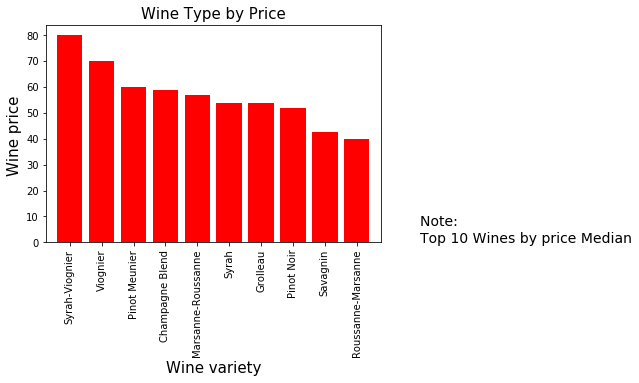

In [6]:
# Plot of wine type by Price

price = winery_df['Price'].tolist()
x_axis = np.arange(10)
plt.bar(x_axis, price[0:10], color='r', alpha= 1, align="center")


varieties = winery_df['Variety'].tolist()
tick = varieties[0: 10]
tick_location = [value for value in x_axis]
plt.xticks(tick_location, tick, rotation = 'vertical')

plt.xlim(-0.75, len(x_axis)-0.25)

plt.title("Wine Type by Price", fontsize = 15)
plt.xlabel("Wine variety", fontsize = 15)
plt.ylabel("Wine price ", fontsize = 15)

plt.text(11, 0, "Note: \nTop 10 Wines by price Median", fontsize = 14)

In [7]:
# varieties = winery_df['Variety'].tolist()
# tick = varieties[0: 9]
# tick_location = [value for value in x_axis]
# plt.xticks(tick_location, tick)

In [8]:
winery_max_price = wine_df.groupby(['Variety'])['Price'].max().to_frame()
winery_max_price = winery_df.sort_values(by=["Price"], ascending = False)

In [9]:
winery_max_price.head(10)

,Variety,Price
0,Syrah-Viognier,80.0
1,Viognier,70.0
2,Pinot Meunier,60.0
3,Champagne Blend,59.0
4,Marsanne-Roussanne,57.0
5,Syrah,54.0
6,Grolleau,54.0
7,Pinot Noir,52.0
8,Savagnin,42.5
11,Chardonnay,40.0


In [10]:
# df2 = winery_df.reset_index().sort_values(['year'])
winery_max_points = wine_df.groupby(['Variety'])['Points'].max().to_frame()

winery_competitive_score = winery_max_price.merge(winery_max_points, how = 'inner', on = 'Variety')

winery_competitive_score['ratio'] = winery_competitive_score['Points'] / winery_competitive_score['Price']

winery_competitive_score.sort_values(by='ratio', ascending = False).head()

mean_s = winery_competitive_score['ratio'].mean()

mean_s

4.387303915652285

In [11]:
winery_competitive_score.head()

,Variety,Price,Points,ratio
0,Syrah-Viognier,80.0,91,1.137500
1,Viognier,70.0,95,1.357143
2,Pinot Meunier,60.0,94,1.566667
3,Champagne Blend,59.0,100,1.694915
4,Marsanne-Roussanne,57.0,90,1.578947


In [12]:
winery_df = wine_df.groupby(['Winery','Variety',"State",'Address'])['Points'].median().to_frame()
winery_df = winery_df.sort_values(by=["Points"], ascending = False)
winery_df = winery_df.reset_index()
winery_df.head(10)


,Winery,Variety,State,Address,Points
0,Clos de Tart,Pinot Noir,Burgundy,7~~~~Route des Grands Crus~~~~Morey-Saint-Deni...,98.0
1,Salon,Chardonnay,Champagne,116~~~~North Green Street~~~~West Loop~~~~Chic...,97.5
2,Louis Jadot,Chardonnay,Burgundy,10~~~~place du Pasquier de la Fontaine~~~~Puli...,97.0
3,Château Haut-Brion,Bordeaux-style White Blend,Bordeaux,135~~~~Avenue Jean Jaurès~~~~Pessac~~~~Gironde...,97.0
4,Domaine Leflaive,Chardonnay,Burgundy,10~~~~place du Pasquier de la Fontaine~~~~Puli...,97.0
5,J.L. Chave,Rhône-style Red Blend,Rhône Valley,37~~~~Avenue du Saint-Joseph~~~~Mauves~~~~Ardè...,97.0
6,Château Cheval Blanc,Bordeaux-style Red Blend,Bordeaux,1~~~~Cheval Blanc~~~~Saint-Émilion~~~~Gironde~...,96.0
7,Domaine Jean Grivot,Pinot Noir,Burgundy,6~~~~Rue de la Croix Rameau~~~~Vosne-Romanée~~...,96.0
8,Domaine des Lambrays,Pinot Noir,Burgundy,31~~~~Rue Basse~~~~Morey-Saint-Denis~~~~Côte-d...,96.0
9,Barons de Rothschild,Chardonnay,Champagne,505~~~~Park Avenue~~~~Manhattan~~~~New York~~~...,96.0


In [14]:
# What is the zip code?
def zipCode():
    while True:
        zipCode = input("Enter a Zip Code: ")
        if zipCode.isdigit():
            return zipCode
zipCode()
#Return top ten winery near me
# 

Enter a Zip Code: 12345


'12345'